In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

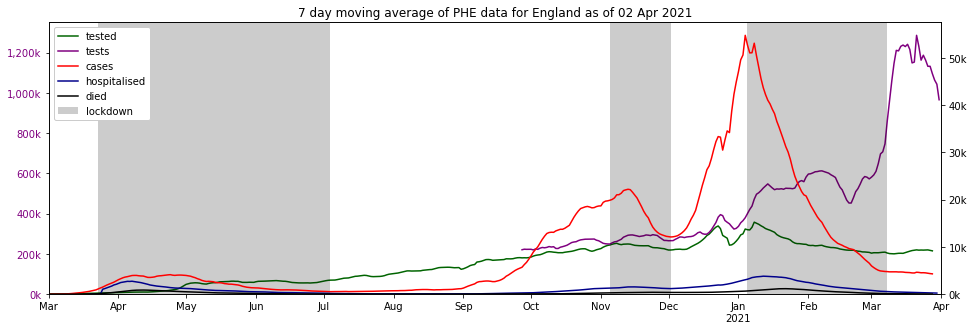

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

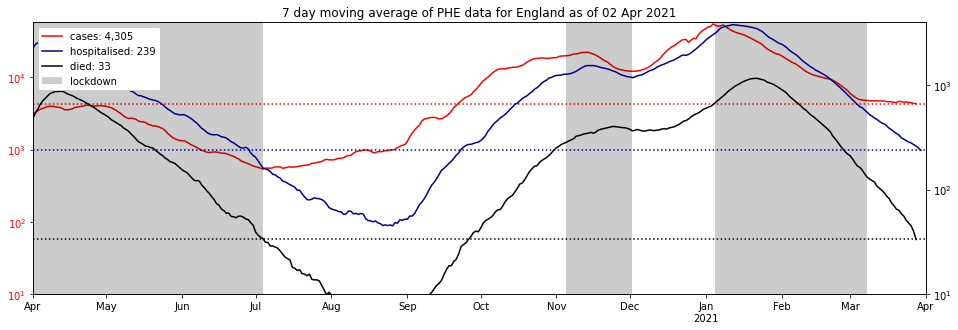

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

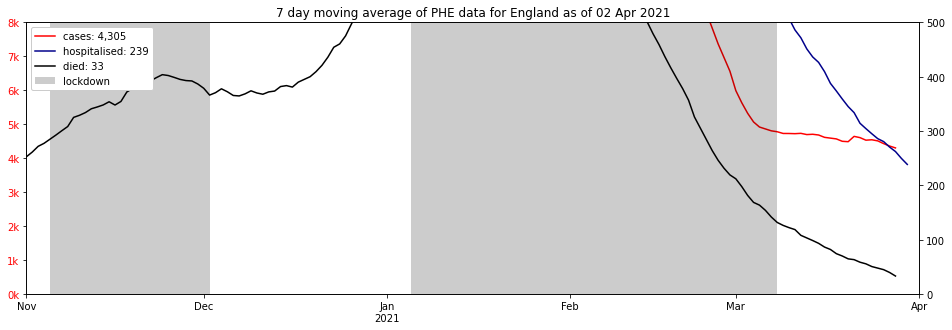

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=8_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

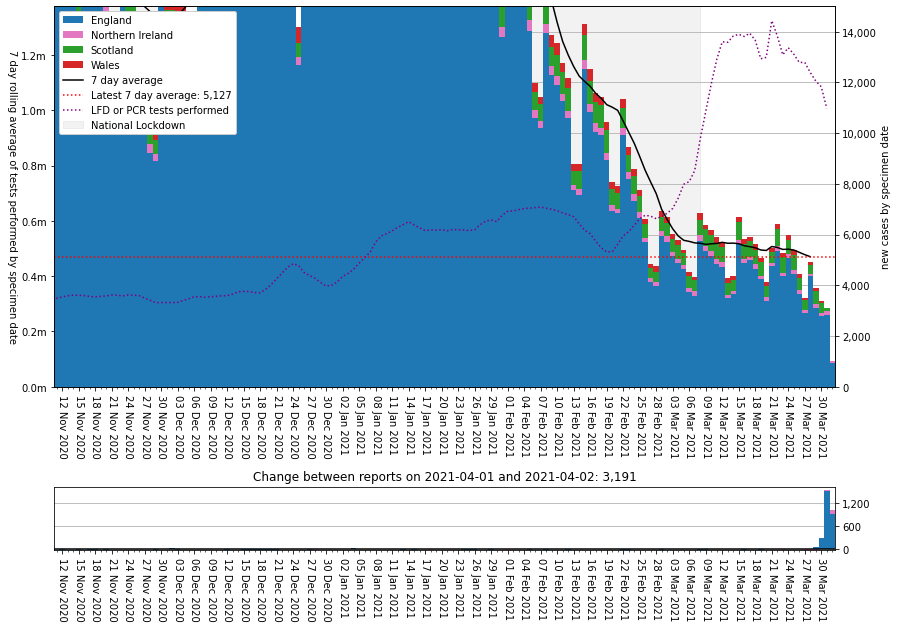

In [5]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,3931103.0,26576629.0,22645526.0,56286961,6.984038,40.232277,52.783685
1,Northern Ireland,N92000002,153454.0,765005.0,611551.0,1893667,8.103537,32.294538,59.601926
2,Scotland,S92000003,414540.0,2515748.0,2101208.0,5463300,7.587722,38.460418,53.951861
3,Wales,W92000004,449538.0,1443885.0,994347.0,3152879,14.258016,31.537747,54.204237


'partial: 31,301,267 (46.9%), full: 4,948,635'

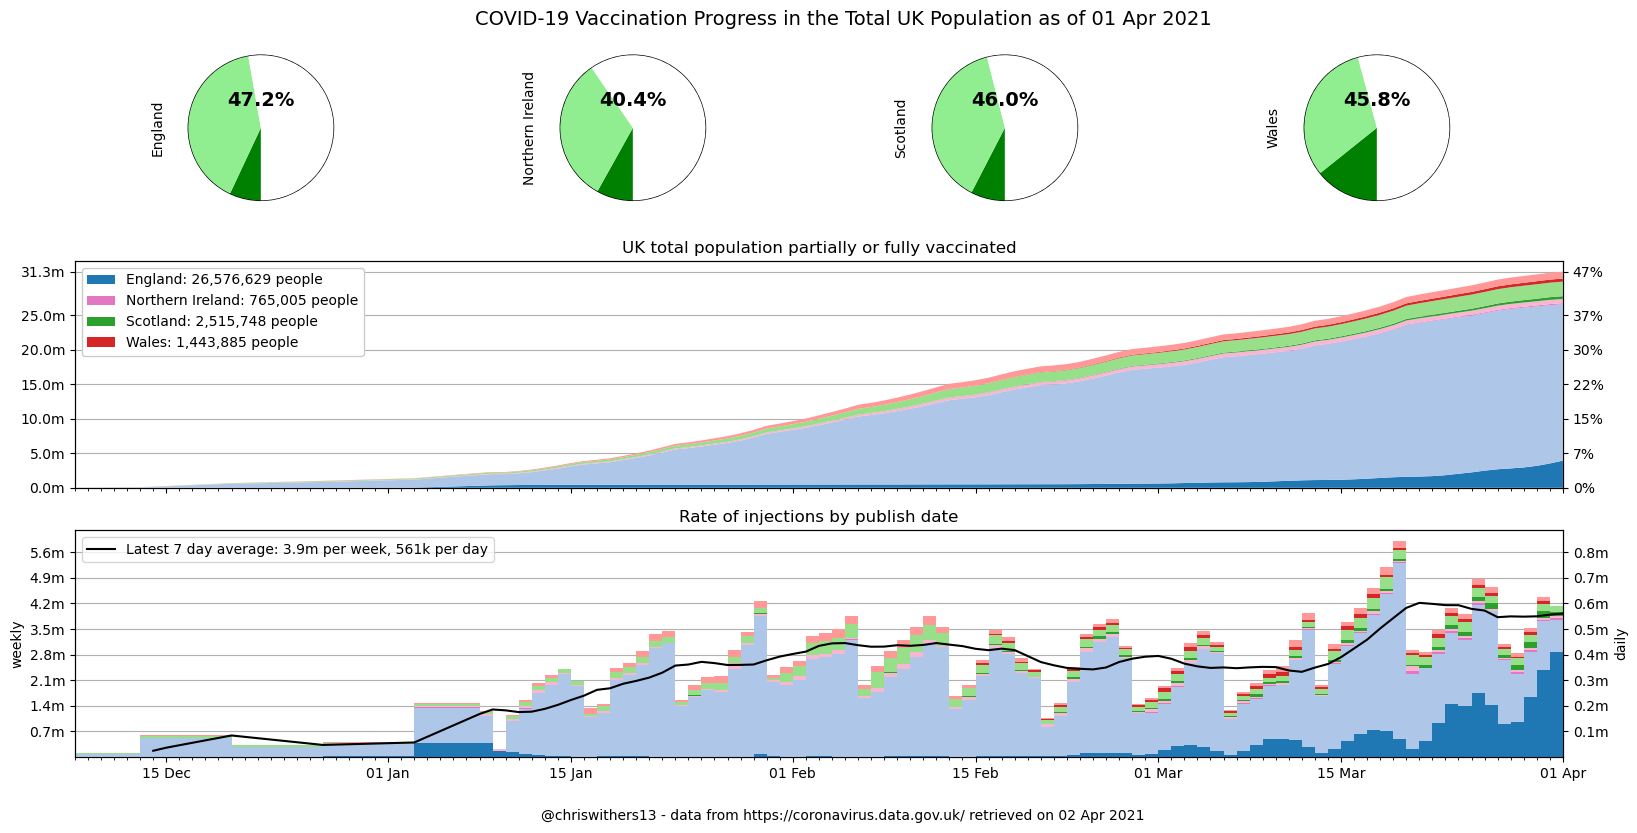

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

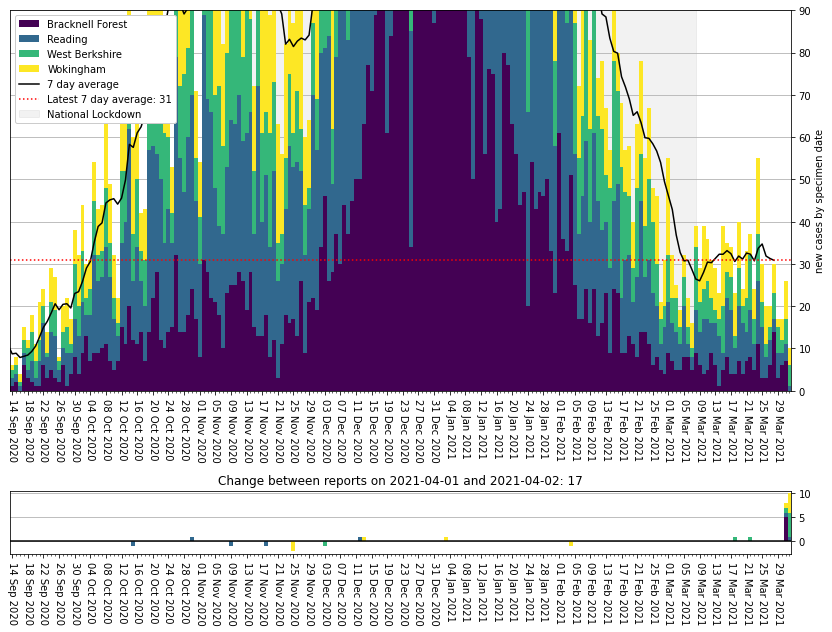

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=90)

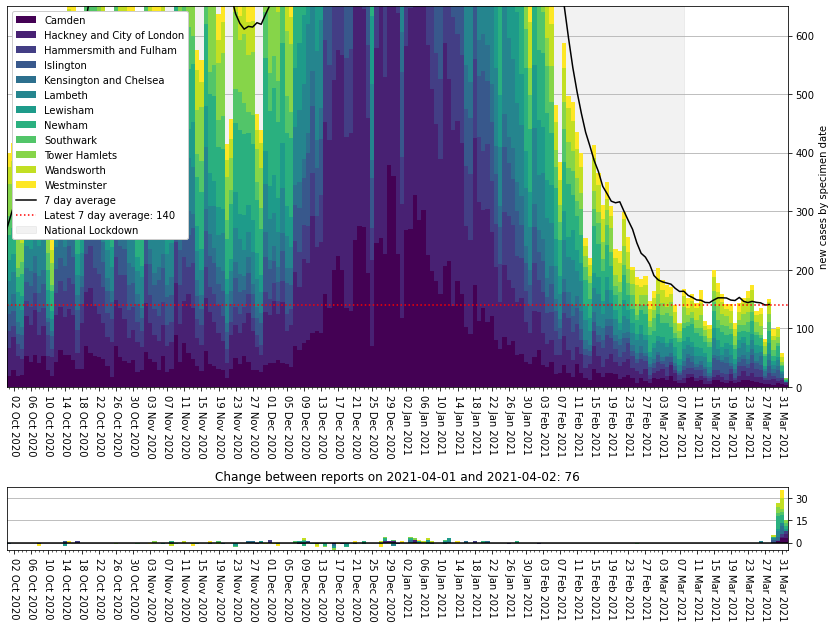

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000005,Clackmannanshire,213.426465,110.0,2021-03-31
E07000150,Corby,157.855382,114.0,2021-04-01
E08000017,Doncaster,112.860303,352.0,2021-04-01
E08000036,Wakefield,102.781414,358.0,2021-04-01
E08000016,Barnsley,99.244124,245.0,2021-04-01
E08000018,Rotherham,97.584501,259.0,2021-04-01
E06000032,Luton,96.220641,205.0,2021-04-01
N09000009,Mid Ulster,95.604869,142.0,2021-04-01
E07000218,North Warwickshire,94.998774,62.0,2021-04-01


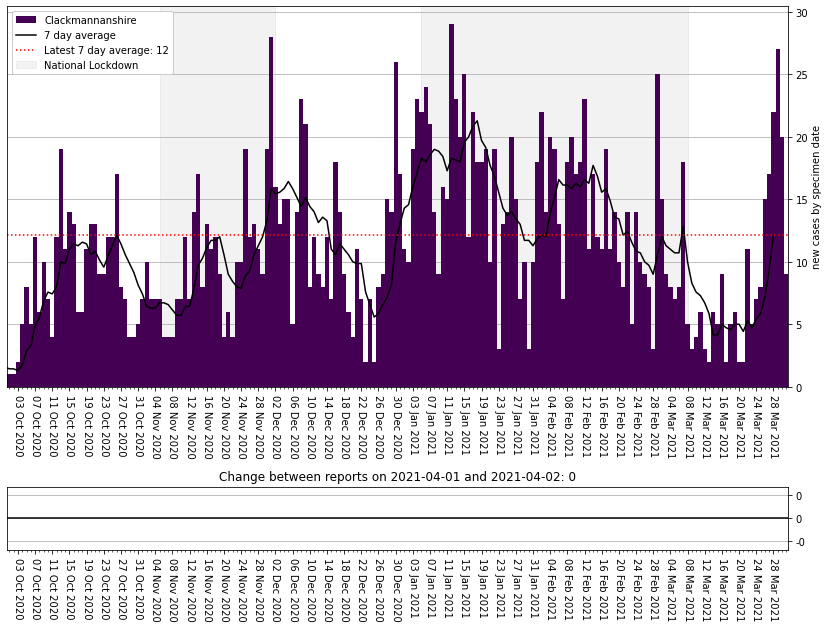

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,81.700686,648.0,2021-04-01
E08000019,Sheffield,86.859433,508.0,2021-04-01
E08000025,Birmingham,44.402951,507.0,2021-04-01
E08000032,Bradford,85.405798,461.0,2021-04-01
E08000003,Manchester,69.095500,382.0,2021-04-01
E08000036,Wakefield,102.781414,358.0,2021-04-01
E08000017,Doncaster,112.860303,352.0,2021-04-01
S12000049,Glasgow City,53.386404,338.0,2021-03-31
E08000034,Kirklees,65.713630,289.0,2021-04-01


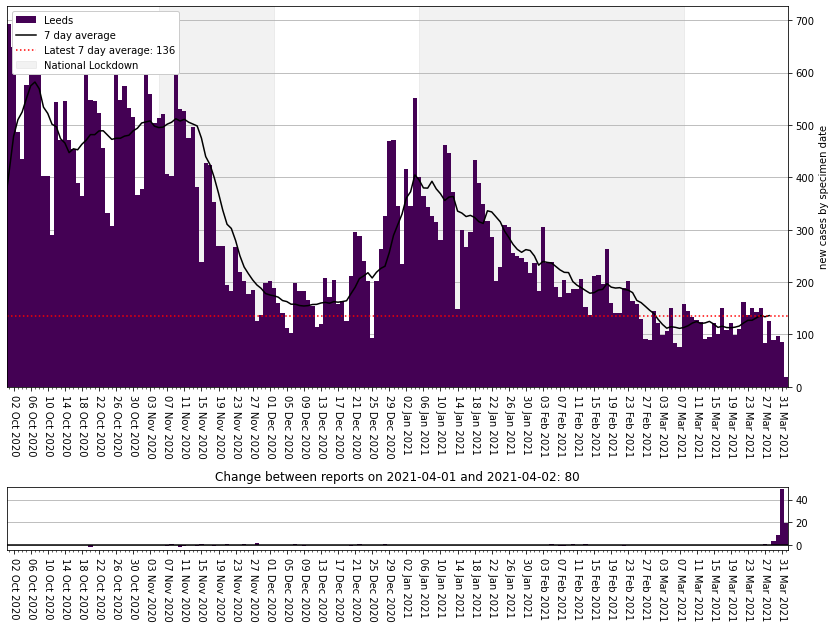

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.25

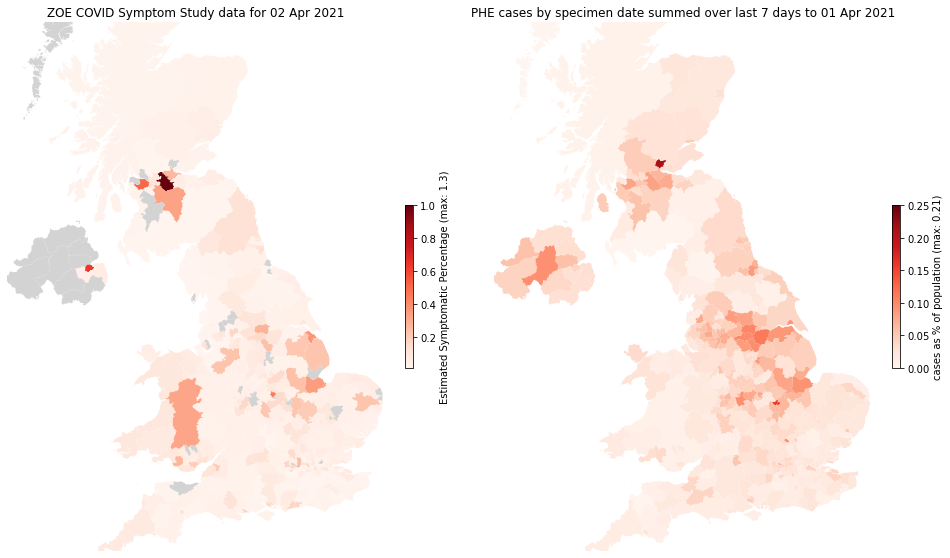

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:


bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...